# RNN with TensorFlow TimeSeries Prediction

In [0]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

## The DATA

In [0]:
class TimeSeriesData():
  
  def __init__(self, num_points, xmin, xmax):
    
    self.xmin = xmin
    self.xmax = xmax
    self.num_points = num_points
    self.resolution = (xmax-xmin)/num_points
    self.x_data = np.linspace(xmin,xmax,num_points)
    self.y_true = np.sin(self.x_data)
    
  def ret_true(self, x_series):
    return np.sin(x_series)
  
  def next_batch(self, batch_size,steps,return_batch_ts = False):
    
    #Grab random starting point for each batch
    rand_start = np.random.rand(batch_size,1)
    #Convert to be on time series
    ts_start = rand_start * (self.xmax - self.xmin -(steps*self.resolution))
    #Create batch time series on the x  axis
    batch_ts = ts_start + np.arange(0.0, steps+1) * self.resolution
    #Create the Y data for the time series in the batches
    y_batch = np.sin(batch_ts)
    #Format for RNN
    if return_batch_ts:
      return y_batch[:,:-1].reshape(-1, steps, 1), y_batch[:, 1:].reshape(-1, steps, 1), batch_ts
    
    else:
       return y_batch[:,:-1].reshape(-1, steps, 1), y_batch[:, 1:].reshape(-1, steps, 1)
    

In [0]:
ts_data = TimeSeriesData(250,0,10)

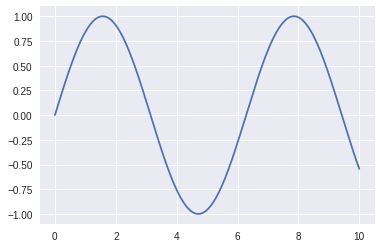

In [4]:
plt.plot(ts_data.x_data, ts_data.y_true)

In [0]:
#Num of steps in batch (also used for prediction steps into the feature)
num_time_steps = 30

In [0]:
y1, y2, ts = ts_data.next_batch(1, num_time_steps, True)

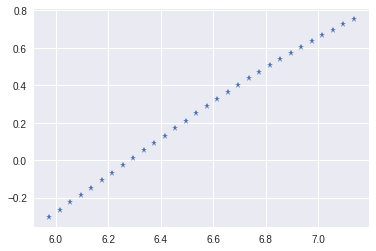

In [7]:
plt.plot(ts.flatten()[1:],y2.flatten(),'*')

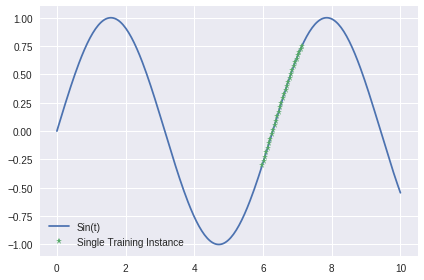

In [8]:
plt.plot(ts_data.x_data,ts_data.y_true,label='Sin(t)')
plt.plot(ts.flatten()[1:],y2.flatten(),'*',label='Single Training Instance')
plt.legend()
plt.tight_layout()

## A Training Instance and what to predict

We are trying to predict a time series shifted over by t+1

In [0]:
train_inst = np.linspace(5,5 + ts_data.resolution * (num_time_steps +1 ), num_time_steps+1)

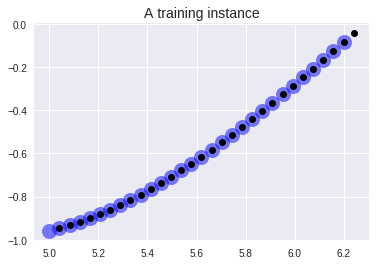

In [10]:
plt.title("A training instance", fontsize = 14)
plt.plot(train_inst[:-1], ts_data.ret_true(train_inst[:-1]),"bo",markersize=15, alpha=0.5, label="instance")
plt.plot(train_inst[1:], ts_data.ret_true(train_inst[1:]), "ko",markersize=7, label="target")

## Creating the Model

In [0]:
tf.reset_default_graph()

### Constants

In [0]:
# Just one feature, the time series
num_inputs = 1
#100 neuron layer, play with this
num_neurons =100
#just one output, predicted time series
num_outputs = 1
#Learning rate, 0.0001 default, but you can change it
learning_rate = 0.0001
#how many iterations to go through(training steps)
num_train_iterations = 2500
#Size of the batch of data
batch_size = 1

### Placeholders

In [0]:
X = tf.placeholder(tf.float32, [None, num_time_steps, num_inputs])
y = tf.placeholder(tf.float32, [None, num_time_steps, num_outputs])

## RNN Cell Layer

In [15]:
cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.BasicRNNCell(num_units=num_neurons, activation = tf.nn.relu),
    output_size = num_outputs)

Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.


### Dynamic RNN Cell

In [0]:
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

### Loss Function and Optimizer

In [0]:
loss = tf.reduce_mean(tf.square(outputs-y)) #MSE
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train = optimizer.minimize(loss)

### Init Variables

In [0]:
init = tf.global_variables_initializer()

## Session

In [22]:
saver = tf.train.Saver()
with tf.Session() as sess:
  
  sess.run(init)
  
  for iteration in range(num_train_iterations):
    
    X_batch, y_batch = ts_data.next_batch(batch_size, num_time_steps)
    sess.run(train, feed_dict={X: X_batch, y:y_batch})
    
    if iteration % 100 == 0:
      mse = loss.eval(feed_dict={X:X_batch, y:y_batch})
      print(iteration, "\tMSE:", mse)
      
    saver.save(sess, "./rnn_time_series_codealong2")  

0 	MSE: 0.11055924
100 	MSE: 0.09617458
200 	MSE: 0.019534873
300 	MSE: 0.0040940433
400 	MSE: 0.007127954
500 	MSE: 0.021409346
600 	MSE: 0.006995765
700 	MSE: 0.024867948
800 	MSE: 0.02512957
900 	MSE: 0.0049307835
1000 	MSE: 0.0045426646
1100 	MSE: 0.0009920177
1200 	MSE: 0.010060877
1300 	MSE: 0.0005478815
1400 	MSE: 0.0053197653
1500 	MSE: 0.0026699787
1600 	MSE: 0.000946849
1700 	MSE: 0.0010495469
1800 	MSE: 0.0070893182
1900 	MSE: 0.00083527045
2000 	MSE: 0.00014483609
2100 	MSE: 0.0048906
2200 	MSE: 0.000121704965
2300 	MSE: 0.0013156424
2400 	MSE: 0.0009090943


## Predicting

In [23]:
with tf.Session() as sess:
    saver.restore(sess,"./rnn_time_series_codealong2")
    
    X_new = np.sin(np.array(train_inst[:-1].reshape(-1,num_time_steps,num_inputs)))
    y_pred = sess.run(outputs,feed_dict={X:X_new})

INFO:tensorflow:Restoring parameters from ./rnn_time_series_codealong2


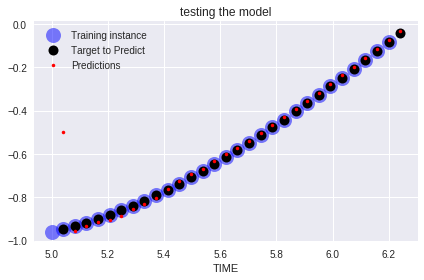

In [24]:
plt.title("testing the model")

#training instance
plt.plot(train_inst[:-1],np.sin(train_inst[:-1]),'bo',markersize=15,alpha=0.5,label='Training instance')
#target to predict
plt.plot(train_inst[1:],np.sin(train_inst[1:]),'ko',markersize = 10,label='Target to Predict')
#models prediction
plt.plot(train_inst[1:],y_pred[0,:,0],'r.',markersize=7,label='Predictions')

plt.xlabel('TIME')
plt.legend()
plt.tight_layout()

## Generating New Sequence

In [26]:
with tf.Session() as sess:
  
  saver.restore(sess,"./rnn_time_series_codealong2")
  
  zero_seq_seed = [0.0 for i in range(num_time_steps)]
  
  for iteration in range(len(ts_data.x_data)-num_time_steps):
    X_batch = np.array(zero_seq_seed[-num_time_steps:]).reshape(1,num_time_steps,1)
    
    y_pred = sess.run(outputs, feed_dict={X:X_batch})
    
    zero_seq_seed.append(y_pred[0,-1,0])

INFO:tensorflow:Restoring parameters from ./rnn_time_series_codealong2


Text(0, 0.5, 'Y')

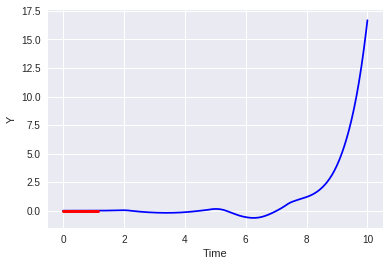

In [28]:
plt.plot(ts_data.x_data, zero_seq_seed,'b-')
plt.plot(ts_data.x_data[:num_time_steps],zero_seq_seed[:num_time_steps],'r',linewidth=3)
plt.xlabel('Time')
plt.ylabel('Y')

In [29]:
with tf.Session() as sess:
    
    saver.restore(sess,"./rnn_time_series_codealong2")
    
  
    training_instance = list(ts_data.y_true[:30])
    
    for iteration in range(len(training_instance)-num_time_steps):
        
        X_batch = np.array(training_instance[-num_time_steps:]).reshape(1,num_time_steps,1)
        
        y_pred = sess.run(outputs, feed_dict={X:X_batch})
        
        training_instance.append(y_pred[0,-1,0])

INFO:tensorflow:Restoring parameters from ./rnn_time_series_codealong2


Text(0, 0.5, 'Y')

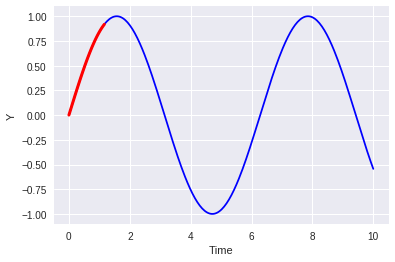

In [30]:
plt.plot(ts_data.x_data,ts_data.y_true,'b-')
plt.plot(ts_data.x_data[:num_time_steps],training_instance[:num_time_steps],'r',linewidth=3)
plt.xlabel('Time')
plt.ylabel('Y')

# THE END